In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-2quocyo4
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-2quocyo4
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=bad82440a922a88e3e45fe6f098f3bd8a120cbb23e985f4c6afa5e5ae24728fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-o7x06my5/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
from keras_vggface.vggface import VGGFace
from keras.models import Model
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
!unzip posGen.zip
!unzip posTrue.zip
!unzip negGen.zip
!unzip negTrue.zip

In [ ]:
def extract_features(X, model):
    old = X[:, 0, :, :]
    new = X[:, 1, :, :]

    features_old = model.predict(old, verbose=1, batch_size=256)
    features_new = model.predict(new, verbose=1, batch_size=256)

    return features_old, features_new

def load_data(path, imgs):
    data = []
    for img in imgs:
        img_loaded = cv2.imread(path + '/' + img)
        try:
            img_loaded = cv2.resize(img_loaded, (224, 224))
        except Exception as e:
            print(img)
        data.append(img_loaded)
    data = np.array(data)
    return data

def build_dataset(pos_X, neg_X):
    pos_neg_X = np.vstack((pos_X, neg_X))
    X = []
    for img in range(0, len(pos_neg_X), 2):
        X.append(np.array([pos_neg_X[img], pos_neg_X[img + 1]]))
    X = np.array(X)
    return X

def extract_featimg_loadedres(X, model):
    old = X[:, 0, :, :]
    new = X[:, 1, :, :]

    features_old = model.predict(old, verbose=1, batch_size=256)
    features_new = model.predict(new, verbose=1, batch_size=256)
  
    return features_old, features_new

def pca_transform(features_new, features_old):
    X_new_pca, _, A_new, Xm_new, _ = pca(features_new, n_components=10)
    X_old_pca, _, A_old, Xm_old, _ = pca(features_old, n_components=10)
  
    return X_new_pca, A_new, Xm_new, X_old_pca, A_old, Xm_old

In [ ]:
layer_name_vggface = 'fc7'

vgg_model = VGGFace(input_shape=(224, 224, 3))
out = vgg_model.get_layer(layer_name_vggface).output
vgg_model_new = Model(vgg_model.input, out)





580075520/580070376 [==============================] - 17s 0us/step








In [ ]:
type_pos = 'posGen'
type_neg = 'negGen'

In [ ]:
pos_imgs = os.listdir(type_pos)
pos_imgs.sort()

neg_imgs = os.listdir(type_neg)
neg_imgs.sort()

In [ ]:
#neg_imgs.remove('.DS_Store')
#pos_imgs.remove('.DS_Store')

In [ ]:
pos_X = load_data(type_pos, pos_imgs)
neg_X = load_data(type_neg, neg_imgs)

In [ ]:
X_test = build_dataset(pos_X, neg_X)
X_test.shape

(1238, 2, 224, 224, 3)

In [ ]:
len(neg_imgs)

1238

In [ ]:
%time X_new_features_test, X_old_features_test = extract_features(X_test, vgg_model_new)

1238/1238 [==============================] - 10s 8ms/step
CPU times: user 2.15 s, sys: 1.17 s, total: 3.32 s
Wall time: 21.1 s


In [ ]:
def get_matrix(X_new, X_old, estimator):
    matrix = np.zeros((X_new.shape[0], X_old.shape[0]))
    for i in range(X_new.shape[0]):
        for j in range(X_old.shape[0]):
            matrix[i][j] = np.array([estimator.predict_proba(np.concatenate([X_new[i], X_old[j]]).reshape(1, -1))[0][1]]).reshape(1, -1)
    return matrix

In [ ]:
from sklearn.preprocessing import normalize


X_new_features_test_pos = X_new_features_test[:X_new_features_test.shape[0]//2]
X_old_features_test_pos = X_old_features_test[:X_old_features_test.shape[0]//2]

X_old_norm = normalize(X_old_features_test_pos, norm='l1', axis=1, copy=True, return_norm=False)
X_new_norm = normalize(X_new_features_test_pos, norm='l1', axis=1, copy=True, return_norm=False)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

SS = cosine_similarity(X_old_norm, X_new_norm)

In [ ]:
diagonal = SS.diagonal()
non_diagonal = SS[np.where(~np.eye(SS.shape[0],dtype=bool))]

diagonal.shape, non_diagonal.shape

((619,), (382542,))

In [ ]:
import math

mu_1, sigma_1 = np.mean(diagonal), np.std(diagonal)
mu_2, sigma_2 = np.mean(non_diagonal), np.std(non_diagonal)

d = math.fabs(mu_2 - mu_1) / math.sqrt((sigma_1**2 + sigma_2**2) / 2)
d

2.2281492318577056

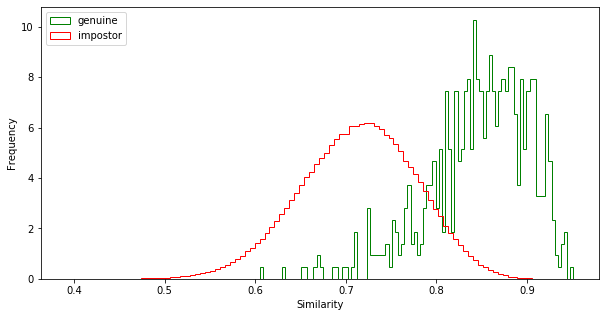

In [ ]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,5))
plt.hist(diagonal, 100, label='genuine', histtype='step', density=True, color='green', stacked=True)
plt.hist(non_diagonal, 100, label='impostor', histtype='step', density=True, color='red', stacked=True)
plt.legend()
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.savefig('feats_ignacio.png', dpi=300, pad_inches=0.1, bbox_inches='tight')
plt.show()

In [ ]:
#Nuevo dataset

#True: 2.490270803488448

#Gen: 2.2281492318577056

In [ ]:
#TRUE: 2.696893315881101

#GEN: 2.573870233264778

In [ ]:
# Mujeres Gen: 2.262951049325408
# Muejeres True: 2.4104501919900763

# Hombres Gen: 2.326349082351052
# Hombres True: 2.480918577312695

# Comparacion

## Best

### True

In [ ]:
true_SS = np.load('SS_True.npy')

In [ ]:
diagonal = true_SS.diagonal()

In [ ]:
diagonal.argsort()[-10:][::-1] * 2

array([  58, 1732,  368, 1730,  556, 1598,  908,  588,   56, 1844])

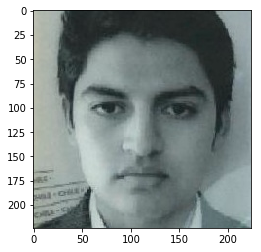

In [ ]:
plt.imshow(pos_X[556])

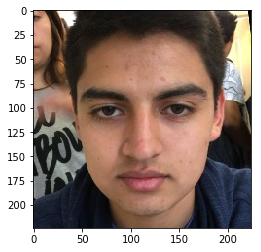

In [ ]:
image = pos_X[557]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

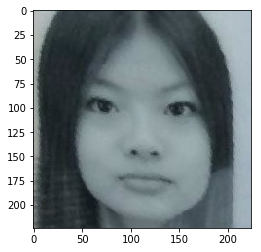

In [ ]:
plt.imshow(pos_X[1598])

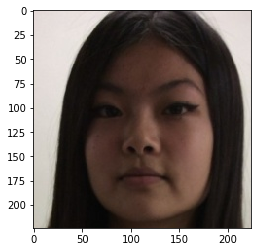

In [ ]:
image = pos_X[1599]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

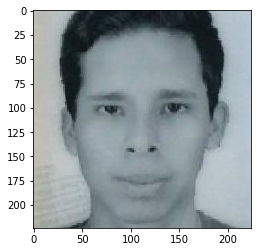

In [ ]:
plt.imshow(pos_X[908])

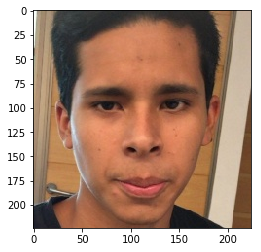

In [ ]:
image = pos_X[909]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

### Gen

In [ ]:
gen_SS = np.load('SS_Gen.npy')

In [ ]:
diagonal = gen_SS.diagonal()

In [ ]:
diagonal.argsort()[-10:][::-1] * 2

array([1598,  382, 1602,  102, 2006,  240,  656, 1010,   58,  910])

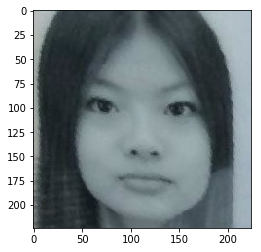

In [ ]:
plt.imshow(pos_X[1598])

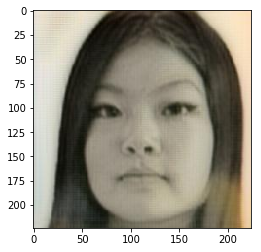

In [ ]:
image = pos_X[1599]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

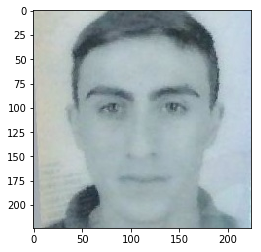

In [ ]:
plt.imshow(pos_X[382])

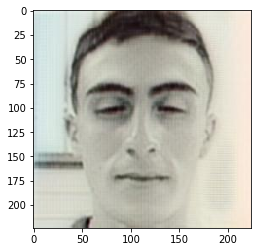

In [ ]:
image = pos_X[383]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

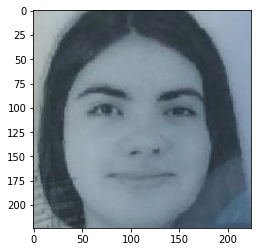

In [ ]:
plt.imshow(pos_X[1602])

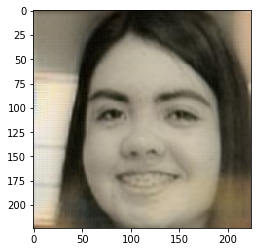

In [ ]:
image = pos_X[1603]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

## Worst

### True

In [ ]:
true_SS = np.load('SS_True.npy')

In [ ]:
diagonal = true_SS.diagonal()

In [ ]:
diagonal.argsort()[:3] * 2

array([ 702, 1786, 1156])

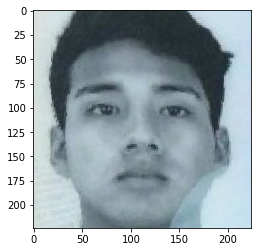

In [ ]:
plt.imshow(pos_X[702])

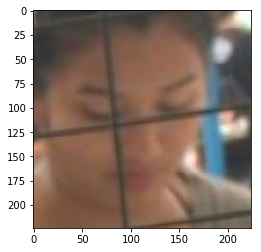

In [ ]:
image = pos_X[703]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

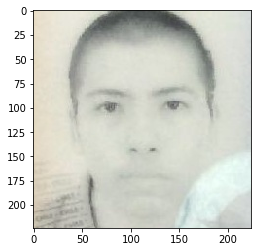

In [ ]:
plt.imshow(pos_X[1786])

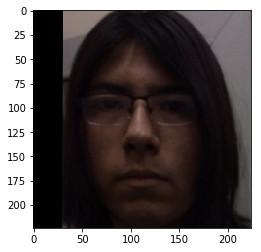

In [ ]:
image = pos_X[1787]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

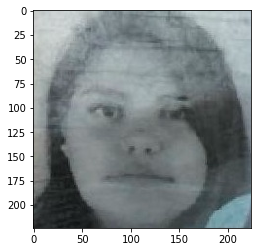

In [ ]:
plt.imshow(pos_X[1156])

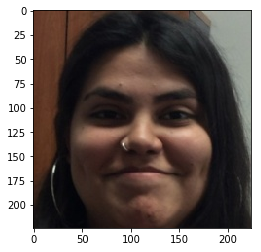

In [ ]:
image = pos_X[1157]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

### Gen

In [ ]:
gen_SS = np.load('SS_Gen.npy')

In [ ]:
diagonal = gen_SS.diagonal()

In [ ]:
diagonal.argsort()[:3] * 2

array([ 702,  954, 2064])

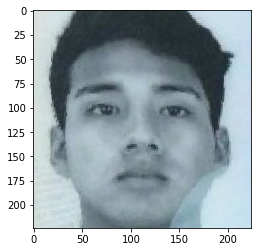

In [ ]:
plt.imshow(pos_X[702])

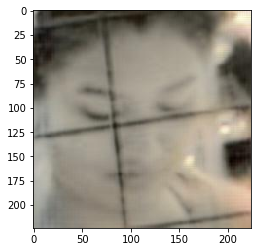

In [ ]:
image = pos_X[703]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

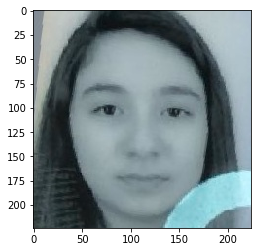

In [ ]:
plt.imshow(pos_X[954])

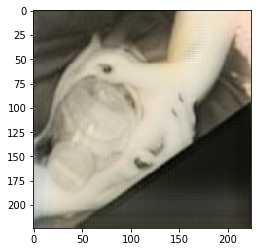

In [ ]:
image = pos_X[955]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

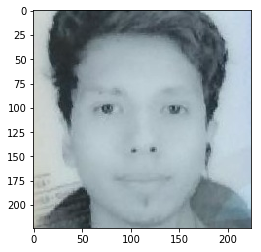

In [ ]:
plt.imshow(pos_X[2064])

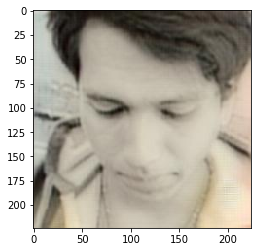

In [ ]:
image = pos_X[2065]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

## Differences

In [ ]:
SS_true = np.load('SS_True.npy')
SS_gen = np.load('SS_Gen.npy')

In [ ]:
ss_true_diagonal = SS_true.diagonal()
ss_gen_diagonal = SS_gen.diagonal()

In [ ]:
from sklearn.metrics import mean_squared_error 

In [ ]:
abs(ss_true_diagonal - ss_gen_diagonal).argsort()[-10:][::-1]

array([ 184,  504,  930,  787,  556, 1039,  932,  855,  931,  482])

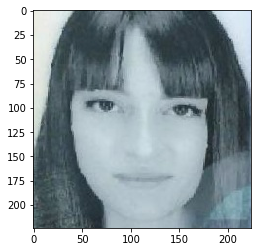

In [ ]:
plt.imshow(pos_X[184 * 2])

In [ ]:
ss_true_diagonal[184]

0.9852146

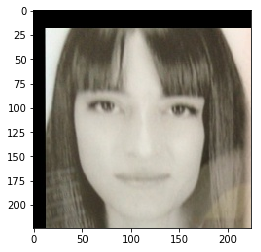

In [ ]:
image = pos_X[184 * 2 + 1]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

In [ ]:
ss_gen_diagonal[184]

0.7855195

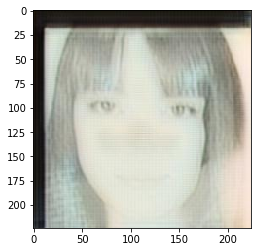

In [ ]:
image = pos_X[184 * 2 + 1]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

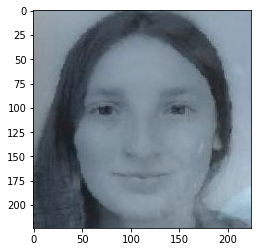

In [ ]:
plt.imshow(pos_X[504 * 2])

In [ ]:
ss_true_diagonal[504]

0.91332597

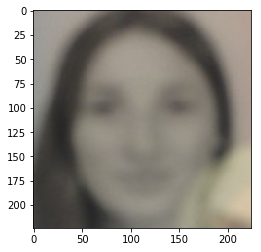

In [ ]:
image = pos_X[504 * 2 + 1]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

In [ ]:
ss_gen_diagonal[504]

0.7839624

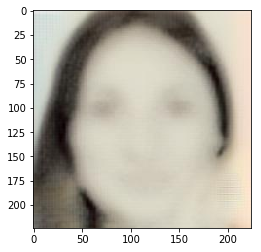

In [ ]:
image = pos_X[504 * 2 + 1]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

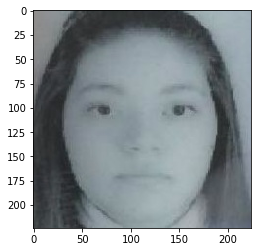

In [ ]:
plt.imshow(pos_X[930 * 2])

In [ ]:
ss_true_diagonal[930]

0.8051639

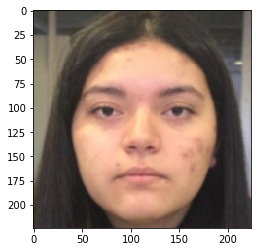

In [ ]:
image = pos_X[930 * 2 + 1]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

In [ ]:
ss_gen_diagonal[930]

0.9203626

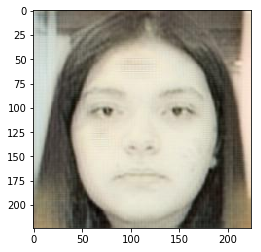

In [ ]:
image = pos_X[930 * 2 + 1]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

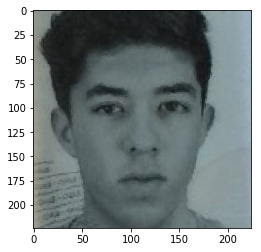

In [ ]:
plt.imshow(pos_X[787 * 2])

In [ ]:
ss_true_diagonal[787]

0.84911674

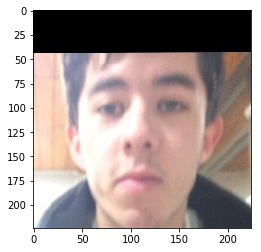

In [ ]:
image = pos_X[787 * 2 + 1]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)

In [ ]:
ss_gen_diagonal[787]

0.73719966

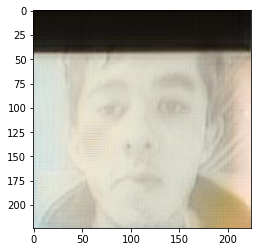

In [ ]:
image = pos_X[787 * 2 + 1]
im2 = image.copy()
im2[:, :, 0] = image[:, :, 2]
im2[:, :, 2] = image[:, :, 0]
plt.imshow(im2)